### Mapping Vaccination Rate at local level for Scotland and England

### Data Sources:

As of 05/20

NHS England publishes weekly vaccination data at :

NHS England: https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-vaccinations/

ONS population estimates: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland


NHS Scotland publishes daily vaccination data at:

NHS Scotland: https://www.opendata.nhs.scot/dataset/covid-19-vaccination-in-scotland

The boundary file is downloaded from
Shapefile: https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2020-uk-buc

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

### England

#### Read in the spreadsheet locate the right sheet and table.

In [2]:
vac_eng = pd.read_excel("data/COVID-19-weekly-announced-vaccinations-20-May-2021.xlsx",
              sheet_name="LTLA",
              header=[11,12],
              skipfooter=8)

In [3]:
vac_eng = vac_eng.drop([0,1]).reset_index()

In [4]:
vac_eng.head()

index Unnamed: 0_level_0 Region Code (Administrative)  \
        Unnamed: 0_level_1           Unnamed: 1_level_1   
0     2                NaN                    E12000004   
1     3                NaN                    E12000004   
2     4                NaN                    E12000004   
3     5                NaN                    E12000004   
4     6                NaN                    E12000004   

  Region Name (administrative)          UTLA Code          UTLA Name  \
            Unnamed: 2_level_1 Unnamed: 3_level_1 Unnamed: 4_level_1   
0                East Midlands          E10000007         Derbyshire   
1                East Midlands          E10000024    Nottinghamshire   
2                East Midlands          E10000024    Nottinghamshire   
3                East Midlands          E10000018     Leicestershire   
4                East Midlands          E10000007         Derbyshire   

           LTLA Code          LTLA Name 1st dose5          ... 2nd dose5  \
  Unnamed: 5_level_1 Unnamed: 6_level_1  Under 40   40-44  ...     45-49   
0          E07000032       Amber Valley    9163.0  6232.0  ...    1811.0   
1          E07000170           Ashfield   10793.0  5632.0  ...    2500.0   
2          E07000171          Bassetlaw    9676.0  5379.0  ...    2565.0   
3          E07000129              Blaby   10437.0  5165.0  ...    1870.0   
4          E07000033           Bolsover    6932.0  3491.0  ...    1413.0   

                                                                 \
    50-54   55-59   60-64   65-69   70-74   75-79     80+ 80+.1   
0  2580.0  2978.0  4286.0  6857.0  7794.0  5673.0  6613.0   NaN   
1  3288.0  3637.0  3806.0  5661.0  6036.0  4964.0  5711.0   NaN   
2  4330.0  4795.0  5232.0  6074.0  6889.0  5109.0  6160.0   NaN   
3  2509.0  2706.0  3631.0  4892.0  5519.0  4071.0  5414.0   NaN   
4  2125.0  2351.0  2879.0  3760.0  4132.0  3329.0  3698.0   NaN   

  Cumulative Total Doses (1st and 2nd doses) to Date6  
                                  Unnamed: 29_level_1  
0                                           121683.0   
1                                           115672.0   
2                                           120188.0   
3                                            97703.0   
4                                            75424.0   

[5 rows x 31 columns]

#### Get the total numbers for people 18+ who received 1 dose and 2 doses respectively.

In [5]:
num_1st = vac_eng.iloc[:,8:18].sum(axis=1)

In [6]:
num_full = vac_eng.iloc[:,19:29].sum(axis=1)

In [7]:
UTLA_name = vac_eng.iloc[:,5]
LTLA_code = vac_eng.iloc[:,6]
LTLA_name = vac_eng.iloc[:,7]

In [8]:
vac_data_eng = pd.concat([UTLA_name,LTLA_code,LTLA_name,num_1st,num_full],axis=1)
vac_data_eng.columns = ['UTLA_name','LTLA_code','LTLA_name','num_1st','num_full']

#### Get the population data from ONS

In [9]:
pop_uk_2019 = pd.read_excel("data/ukmidyearestimates20192020ladcodes.xls",
              sheet_name="MYE2 - Persons",
              header=4,
              skipfooter=2)

In [10]:
pop_uk_2019.head()

,Code,Name,Geography1,All ages,0,1,2,3,4,5,...,81,82,83,84,85,86,87,88,89,90+
0,K02000001,UNITED KINGDOM,Country,66796807,722881,752554,777309,802334,802185,809152,...,372612,344104,316201,288806,255542,230667,210077,186163,159641,605181
1,K03000001,GREAT BRITAIN,Country,64903140,700160,729146,753103,777260,777225,784154,...,363446,335419,308434,281696,249323,224878,205072,181788,156024,591447
2,K04000001,ENGLAND AND WALES,Country,59439840,649388,676412,698837,720721,719821,726317,...,332255,306983,282197,257792,228197,206177,188071,167219,143992,547789
3,E92000001,ENGLAND,Country,56286961,618858,644056,665596,686135,684992,691122,...,312737,289092,265631,242740,214727,194007,177399,157770,135875,517273
4,E12000001,NORTH EAST,Region,2669941,26621,27612,28621,29575,29315,30224,...,16364,15159,13345,12509,10851,9793,8725,7825,6511,22608


#### Compute the population for people aged 18 and over

In [11]:
pop_uk_2019['pop_18_over'] = pop_uk_2019.iloc[:,22:].sum(axis=1)

#### Calculate the % of people vaccinated

In [12]:
vac_pop_eng = pd.merge(vac_data_eng, pop_uk_2019, left_on ="LTLA_code", right_on = "Code")

vac_pop_eng['pct_1dose'] = np.round(vac_pop_eng.num_1st/vac_pop_eng.pop_18_over*100,1)
vac_pop_eng['pct_full'] = np.round(vac_pop_eng.num_full/vac_pop_eng.pop_18_over*100,1)

vac_eng = vac_pop_eng[['LTLA_code', 'LTLA_name', 'pct_1dose', 'pct_full']].copy()

### Scotland

#### Read in the data downloaded from NHS.

In [13]:
full_scot = pd.read_csv("data/d5ffffc0-f6f3-4b76-8f38-71ccfd7747a4-2.csv")
full_scot.tail()

,_id,Date,CA,CAQF,CAName,Sex,SexQF,AgeGroup,AgeGroupQF,Population,...,Dose,DoseQF,NumberVaccinated,NumberVaccinatedQF,PercentCoverage,PercentCoverageQF,CumulativeNumberVaccinated,CumulativeNumberVaccinatedQF,CumulativePercentCoverage,CumulativePercentCoverageQF
365767,365768,20210519,S12000050,NaN,North Lanarkshire,Total,d,60 - 64,NaN,21107.0,...,Dose 2,NaN,140,NaN,0.663287,NaN,9774,NaN,46.306912,NaN
365768,365769,20210519,S12000050,NaN,North Lanarkshire,Total,d,65 - 69,NaN,17976.0,...,Dose 2,NaN,37,NaN,0.205830,NaN,16728,NaN,93.057410,NaN
365769,365770,20210519,S12000050,NaN,North Lanarkshire,Total,d,70 - 74,NaN,15922.0,...,Dose 2,NaN,17,NaN,0.106771,NaN,15392,NaN,96.671272,NaN
365770,365771,20210519,S12000050,NaN,North Lanarkshire,Total,d,75 - 79,NaN,11223.0,...,Dose 2,NaN,20,NaN,0.178205,NaN,10603,NaN,94.475630,NaN
365771,365772,20210519,S12000050,NaN,North Lanarkshire,Total,d,80 years and over,NaN,13978.0,...,Dose 2,NaN,13,NaN,0.093003,NaN,12891,NaN,92.223494,NaN


#### The data is a long format that contains timeseries updates, so we need to do some indexing to get the most recent cumulatives

In [14]:
scot_dose1 = full_scot[(full_scot["Date"] == 20210519) & 
          (full_scot["AgeGroup"] == "18 years and over") & 
          (full_scot["Sex"] == "Total") &
          (full_scot["Dose"] == "Dose 1")
         ].CumulativePercentCoverage.reset_index()

scot_dose2 = full_scot[(full_scot["Date"] == 20210519) & 
          (full_scot["AgeGroup"] == "18 years and over") & 
          (full_scot["Sex"] == "Total") &
          (full_scot["Dose"] == "Dose 2")
         ].CumulativePercentCoverage.reset_index()
scot_code = full_scot[(full_scot["Date"] == 20210519) & 
          (full_scot["AgeGroup"] == "18 years and over") & 
          (full_scot["Sex"] == "Total") &
          (full_scot["Dose"] == "Dose 2")
         ].CA.reset_index()

scot_name = full_scot[(full_scot["Date"] == 20210519) & 
          (full_scot["AgeGroup"] == "18 years and over") & 
          (full_scot["Sex"] == "Total") &
          (full_scot["Dose"] == "Dose 2")
         ].CAName.reset_index()

In [15]:
vac_scot = pd.concat([scot_code,scot_name,scot_dose1,scot_dose2],axis=1).drop(0,axis=0).drop("index",axis=1)
vac_scot.columns = ['LTLA_code', 'LTLA_name', 'pct_1dose', 'pct_full']

#### Merging with the boundary file by LTLA code 

<AxesSubplot:>

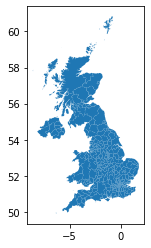

In [16]:
shp = gpd.read_file("https://opendata.arcgis.com/datasets/69dc11c7386943b4ad8893c45648b1e1_0.geojson")
shp.plot()

In [17]:
names = ['LTLA_code', 'LTLA_name', 'pct_1dose','pct_full', 'geometry']

vac_E = gpd.GeoDataFrame(pd.merge(vac_eng, shp, left_on="LTLA_code", right_on="LAD20CD", how="left"))[names]
vac_S = gpd.GeoDataFrame(pd.merge(vac_scot, shp, left_on="LTLA_code", right_on="LAD20CD", how="left"))[names]

#### Project the data to Web-mercator for web mapping.

<AxesSubplot:>

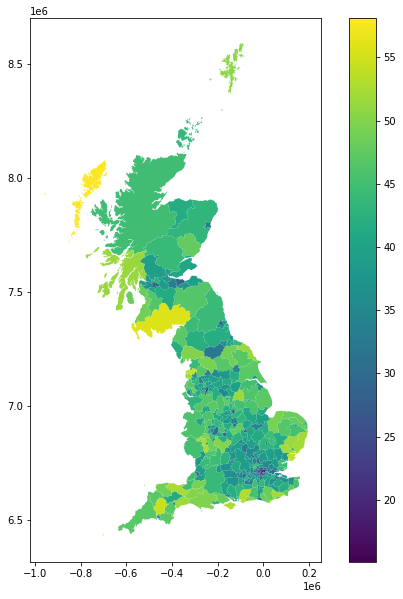

In [18]:
vac_data = pd.concat([vac_E, vac_S]).reset_index()

vac_data = vac_data.to_crs("EPSG:3857") #EPSG for webmercator

vac_data.plot(column="pct_full",legend=True,figsize=(10,10))

#### Export the data to geojson

In [19]:
vac_data.to_file("vac_data_0520.geojson", driver='GeoJSON')